dict_keys(['__header__', '__version__', '__globals__', 'GBgreenabs', 'GBgreenpl', 'Q', 'RGBgreenabs', 'RGBgreenpl', 'RGBorangeabs', 'RGBorangepl', 'blue5'])


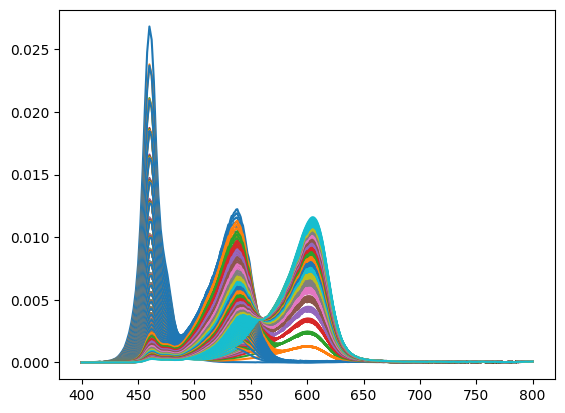

0.5839509963989258


In [101]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import time
import scipy.io as sp
import os
start = time.time()


color_data = sp.loadmat("colordata.mat")
print(color_data.keys())

abs_green_GB = color_data.get("GBgreenabs")
abs_green_RGB = color_data.get("RGBgreenabs")
abs_red_RGB = color_data.get("RGBorangeabs")

PL_green_GB = color_data.get("GBgreenpl")
PL_green_RGB = color_data.get("RGBgreenpl")
PL_red_RGB = color_data.get("RGBorangepl")

blue5 = color_data.get("blue5")

Q = color_data.get("Q")
Q = np.concatenate(Q,axis = 0)

w = np.arange(400,801)
Wavelength = range(380,785,5)

absorbance = np.array([abs_green_GB[:,1]-min(abs_green_GB[:,1]), abs_green_RGB[:,1]-min(abs_green_RGB[:,1]),abs_red_RGB[:,1]-min(abs_red_RGB[:,1])])
PL = np.array([PL_green_GB[:,1]-min(PL_green_GB[:,1]), PL_green_RGB[:,1]-min(PL_green_RGB[:,1]),PL_red_RGB[:,1]-min(PL_red_RGB[:,1])])

PL[0,:] = PL[0,:]/sum(PL[0,:])
PL[1,:] = PL[1,:]/sum(PL[1,:])
PL[2,:] = PL[2,:]/sum(PL[2,:])
PL = PL.T
absorbance = absorbance.T

OD = np.array([abs_green_GB[60,1], abs_green_RGB[60,1], abs_red_RGB[60,1]])

blue5 = blue5[:,1]/sum(blue5[:,1])

alphaa = 2.3*absorbance[:,[1, 2]]
Pa = PL[:,[1, 2]]
QQ = Q[[1, 2]]
QQ = np.array([1, 1])
ODD = OD[[1, 2]]

l = len(QQ.T)

XX = 1./ODD

x = np.linspace(0,XX[0],20)
y = np.linspace(0,XX[1],20)


count = 0
def CC2_LED(w,blue5,alpha,PL,Q,l,D):
    
    alphaa1 = np.zeros(alpha.shape)
    Paa = np.zeros(PL.shape)
    K = np.zeros(PL.shape)
    W = np.zeros(Q.shape)

    w_scale = np.flip(w)/min(w)
    blue5 = blue5*w_scale
    
    blue5 = blue5/sum(blue5)
    
    
        
    alphaa1[:,0] = alphaa[:,0]*D[0]
    alphaa1[:,1] = alphaa[:,1]*D[1]

        
    K[:,0] = alphaa1[:,0]/(alphaa1[:,0]+alphaa1[:,1]+0.000001)
    K[:,1] = alphaa1[:,1]/(alphaa1[:,0]+alphaa1[:,1]+0.000001)

    K[np.isnan(K)] = 0
        
    for k in range(l):
        Paa[:,k] = w_scale*PL[:,k]/sum(PL[:,k]*w_scale)
            
    A = np.exp(-(alphaa1[:,0] + alphaa1[:,1]))
    E = 1 - A
    C = np.zeros((l,l))
        
    for ii in range(l):
        for jj in range(l):
            C[ii,jj] = QQ[jj]*sum(Paa[:,ii]*K[:,jj]*E)
        
    Ci = np.linalg.inv(np.eye(l)-C)
        
    for ii in range(l):
        W[ii] = QQ[ii]*sum(blue5*K[:,ii]*E)
        
    AE = np.matmul(np.matmul(Paa,Ci.T),W)
    S_out = (blue5 + AE)*A/w_scale
    EQE = 100*sum(AE*A) / sum((blue5))

    return S_out, EQE
    

def photometry_calc(Wavelength,S,XYZ,Stdl,TCS):
    
    Wavelength = XYZ[:,0]
    xhat = XYZ[:,1]
    yhat = XYZ[:,2]
    zhat = XYZ[:,3]
    
    S0l = Stdl[:,1]
    S1l = Stdl[:,2]
    S2l = Stdl[:,3]
    
    Xsample = sum(xhat*S/sum(S))
    Ysample = sum(yhat*S/sum(S))
    Zsample = sum(zhat*S/sum(S))
    L = sum(yhat*S)*5*683.002
    LER = Ysample*683.002
    
    xsample = Xsample/(Ysample + Zsample +Xsample);
    ysample = Ysample/(Xsample + Ysample + Zsample);
    usample = 4*Xsample/(Xsample + 15*Ysample +3*Zsample);
    vsample = 6*Ysample/(Xsample + 15*Ysample +3*Zsample);
    
    x_prime = (ysample + 1.67*xsample - 0.885)/1.9495;
    y_prime = (ysample - 0.607*xsample - 0.109)/1.1648;
    elip = (x_prime/0.1339)**2 + (y_prime/0.0944)**2;
    count = np.nan
    if elip<3:
        n = (xsample - 0.3320)/(0.1858 - ysample);
        Tc = (449*n**3) + (3525*n**2) + (6823.3*n) + 5520.33;
        CCT = Tc
        if CCT<10000:
            Tc = CCT
            if CCT<5000:
                c1 = 3.7418e-16
                c2 = 1.4388e-2
                stn = c1 * (1e-9*Wavelength)**-5 / (np.exp(c2/(Tc* 1e-9*Wavelength)) - 1)
            else:
                
                return count/8
        else:
            if CCT<7000:
                xd = -4.6070e9 / Tc**3 + 2.9678e6 / Tc**2 + 0.09911e3 / Tc + 0.244063
            else:
                xd = -2.0064e9 / Tc**3 + 1.9018e6 / Tc**2 + 0.24748e3 / Tc + 0.237040
                
            yd = -3.000*xd*xd + 2.870*xd - 0.275
            M1 = (-1.3515 - 1.7703*xd + 5.9114*yd) / (0.0241 + 0.2562*xd - 0.7341*yd)
            M2 = (0.0300 - 31.4424*xd + 30.0717*yd) / (0.0241 + 0.2562*xd - 0.7341*yd)
            stn = S0l + M1*S1l + M2*S2l
    else:
        
        
        return count/8
    
    Xref = sum(xhat*stn)
    Yref = sum(yhat*stn)
    Zref = sum(zhat*stn)
    
    
    uref = 4*Xref/(Xref + 15*Yref +3*Zref)
    vref = 6*Yref/(Xref + 15*Yref +3*Zref)
    duv = np.sqrt((uref-usample)**2+(vref-vsample)**2)
    
    
    ct = (4 - usample - 10*vsample) / vsample
    dt = (1.708*vsample + 0.404 - 1.481*usample) / vsample
    cr = (4 - uref - 10*vref) / vref
    dr = (1.708*vref + 0.404 - 1.481*uref) / vref
    
    
    
    urs = np.zeros(15)
    vrs = np.zeros(15)
    urr = np.zeros(15)
    vrr = np.zeros(15)
    Ytesti = np.zeros(15)
    Yrefi = np.zeros(15)
    for i in range(1,10):
        XRs= sum(xhat*(S/sum(S))*TCS[:,i]/1000)
        YRs= sum(yhat*(S/sum(S))*TCS[:,i]/1000)
        ZRs= sum(zhat*(S/sum(S))*TCS[:,i]/1000)
            
        urs[i] = 4*XRs/(XRs + 15*YRs +3*ZRs)
        vrs[i] = 6*YRs/(XRs + 15*YRs +3*ZRs)
            
        XRr= sum(xhat*TCS[:,i]*stn/1000)
        YRr= sum(yhat*TCS[:,i]*stn/1000)
        ZRr= sum(zhat*TCS[:,i]*stn/1000)
            
        urr[i] = 4*XRr/(XRr + 15*YRr +3*ZRr)
        vrr[i] = 6*YRr/(XRr + 15*YRr +3*ZRr)
            
        Ytesti[i] = 100*YRs/Ysample
        Yrefi[i] = 100*YRr/Yref
        
    
    ukip = np.zeros(15)
    vkip = np.zeros(15)
    
    for i in range(1,10):
        cki = (4 - urs[i] - 10*vrs[i]) / vrs[i]
        dki = (1.708*vrs[i] + 0.404 - 1.481*urs[i]) / vrs[i]
        ukip[i] = (10.872 + 0.404*cr/ct*cki - 4*dr/dt*dki) / (16.518 + 1.481*cr/ct*cki - dr/dt*dki)
        vkip[i] = 5.520 / (16.518 + 1.481*cr/ct*cki - dr/dt*dki)
    
    
    count = 0
    
    
    deltaL = np.zeros(15)
    LReff = np.zeros(15)
    Ltest = np.zeros(15)
    deltau = np.zeros(15)
    deltav = np.zeros(15)
    deltaE = np.zeros(15)
    CRI = np.zeros(15)
    for i in range(1,10):
        deltaL[i] = (25*(Yrefi[i])**(1/3)-17) - (25*((Ytesti[i]))**(1/3)-17)
        LReff[i] = (25*((Yrefi[i]))**(1/3)-17)
        Ltest[i] = (25*((Ytesti[i]))**(1/3)-17)
            
        deltau[i] = 13*LReff[i]*(urr[i] - uref) - 13*Ltest[i]*(ukip[i] - uref)
            
        deltav[i] = 13*LReff[i]*(vrr[i] - vref) - 13*Ltest[i]*(vkip[i] - vref)
            
        deltaE[i] = np.sqrt(deltaL[i]**2 + deltau[i]**2 + deltav[i]**2)
        CRI[i] = 100-(4.6*deltaE[i])
        count = count +CRI[i]
    
    
    return count/8
    
    
    

    
S_out = np.zeros((len(w),len(x),len(y)))
EQE = np.zeros((len(x),len(y)))
CRI = np.zeros((len(x),len(y)))

for i in range(len(x)):
    for j in range(len(y)):
        D = np.array([x[i], y[j]])
        S_out[:,i,j],EQE[i,j] = CC2_LED(w,blue5,alphaa,Pa,QQ,l,D)
        CRI[i,j] = photometry_calc(Wavelength,np.concatenate([np.zeros(4), S_out[0:-20:5,i,j]]),XYZ,Stdl,TCS)
        plt.plot(w,S_out[:,i,j])
plt.show()    
EQE
end = time.time()
print(end - start)

In [102]:
CRI

array([[         nan,          nan,          nan,          nan,
         41.29051088,          nan,  33.28966788,  23.64444246,
         18.30344363,  15.71898146,  14.40402367,  13.38982253,
         12.46428806,  11.60191507,  10.80064232,  10.1016612 ,
          9.51979241,   9.04747327,   8.67032225,   8.37387837],
       [         nan,          nan,  47.33951708,  57.07211657,
         60.20614009,          nan,  46.25048052,  38.08118063,
         32.0337776 ,  27.85970816,  24.72462335,  22.15046654,
         20.0082355 ,  18.18348837,  16.63088361,  15.32493962,
         14.23381363,  13.32421424,  12.56641407,  11.93558443],
       [         nan,  47.24739083,  67.52534443,  70.14159373,
                 nan,          nan,  53.91234535,  46.85728324,
         40.95524862,  36.13467572,  32.09297582,  28.71583915,
         25.868387  ,  23.45295757,  21.40727901,  19.67736995,
         18.21355126,  16.97262398,  15.91855467,  15.02184177],
       [         nan,  51.35870426,  

In [80]:


Wavelength = range(380,785,5)

SS_out = np.concatenate([np.zeros(4), S_out[0:-20:5,10,5]])



def photometry_calc(Wavelength,S,XYZ,Stdl,TCS):
    
    Wavelength = XYZ[:,0]
    xhat = XYZ[:,1]
    yhat = XYZ[:,2]
    zhat = XYZ[:,3]
    
    S0l = Stdl[:,1]
    S1l = Stdl[:,2]
    S2l = Stdl[:,3]
    
    Xsample = sum(xhat*S/sum(S))
    Ysample = sum(yhat*S/sum(S))
    Zsample = sum(zhat*S/sum(S))
    L = sum(yhat*S)*5*683.002
    LER = Ysample*683.002
    
    xsample = Xsample/(Ysample + Zsample +Xsample);
    ysample = Ysample/(Xsample + Ysample + Zsample);
    usample = 4*Xsample/(Xsample + 15*Ysample +3*Zsample);
    vsample = 6*Ysample/(Xsample + 15*Ysample +3*Zsample);
    
    x_prime = (ysample + 1.67*xsample - 0.885)/1.9495;
    y_prime = (ysample - 0.607*xsample - 0.109)/1.1648;
    elip = (x_prime/0.1339)**2 + (y_prime/0.0944)**2;
    
    if elip<300:
        n = (xsample - 0.3320)/(0.1858 - ysample);
        Tc = (449*n**3) + (3525*n**2) + (6823.3*n) + 5520.33;
        CCT = Tc
        if CCT<10000:
            Tc = CCT
            if CCT<5000:
                c1 = 3.7418e-16
                c2 = 1.4388e-2
                stn = c1 * (1e-9*Wavelength)**-5 / (np.exp(c2/(Tc* 1e-9*Wavelength)) - 1)
        else:
            if CCT<7000:
                xd = -4.6070e9 / Tc^3 + 2.9678e6 / Tc^2 + 0.09911e3 / Tc + 0.244063
            else:
                xd = -2.0064e9 / Tc^3 + 1.9018e6 / Tc^2 + 0.24748e3 / Tc + 0.237040
                
            yd = -3.000*xd*xd + 2.870*xd - 0.275
            M1 = (-1.3515 - 1.7703*xd + 5.9114*yd) / (0.0241 + 0.2562*xd - 0.7341*yd)
            M2 = (0.0300 - 31.4424*xd + 30.0717*yd) / (0.0241 + 0.2562*xd - 0.7341*yd)
            stn = S0l + M1*S1l + M2*S2l
    
    Xref = sum(xhat*stn)
    Yref = sum(yhat*stn)
    Zref = sum(zhat*stn)
    
    
    uref = 4*Xref/(Xref + 15*Yref +3*Zref)
    vref = 6*Yref/(Xref + 15*Yref +3*Zref)
    duv = np.sqrt((uref-usample)**2+(vref-vsample)**2)
    
    
    ct = (4 - usample - 10*vsample) / vsample
    dt = (1.708*vsample + 0.404 - 1.481*usample) / vsample
    cr = (4 - uref - 10*vref) / vref
    dr = (1.708*vref + 0.404 - 1.481*uref) / vref
    
    
    
    urs = np.zeros(15)
    vrs = np.zeros(15)
    urr = np.zeros(15)
    vrr = np.zeros(15)
    Ytesti = np.zeros(15)
    Yrefi = np.zeros(15)
    for i in range(1,10):
        XRs= sum(xhat*(S/sum(S))*TCS[:,i]/1000)
        YRs= sum(yhat*(S/sum(S))*TCS[:,i]/1000)
        ZRs= sum(zhat*(S/sum(S))*TCS[:,i]/1000)
            
        urs[i] = 4*XRs/(XRs + 15*YRs +3*ZRs)
        vrs[i] = 6*YRs/(XRs + 15*YRs +3*ZRs)
            
        XRr= sum(xhat*TCS[:,i]*stn/1000)
        YRr= sum(yhat*TCS[:,i]*stn/1000)
        ZRr= sum(zhat*TCS[:,i]*stn/1000)
            
        urr[i] = 4*XRr/(XRr + 15*YRr +3*ZRr)
        vrr[i] = 6*YRr/(XRr + 15*YRr +3*ZRr)
            
        Ytesti[i] = 100*YRs/Ysample
        Yrefi[i] = 100*YRr/Yref
        
    
    ukip = np.zeros(15)
    vkip = np.zeros(15)
    
    for i in range(1,10):
        cki = (4 - urs[i] - 10*vrs[i]) / vrs[i]
        dki = (1.708*vrs[i] + 0.404 - 1.481*urs[i]) / vrs[i]
        ukip[i] = (10.872 + 0.404*cr/ct*cki - 4*dr/dt*dki) / (16.518 + 1.481*cr/ct*cki - dr/dt*dki)
        vkip[i] = 5.520 / (16.518 + 1.481*cr/ct*cki - dr/dt*dki)
    
    
    count = 0
    
    
    deltaL = np.zeros(15)
    LReff = np.zeros(15)
    Ltest = np.zeros(15)
    deltau = np.zeros(15)
    deltav = np.zeros(15)
    deltaE = np.zeros(15)
    CRI = np.zeros(15)
    for i in range(1,10):
        deltaL[i] = (25*(Yrefi[i])**(1/3)-17) - (25*((Ytesti[i]))**(1/3)-17)
        LReff[i] = (25*((Yrefi[i]))**(1/3)-17)
        Ltest[i] = (25*((Ytesti[i]))**(1/3)-17)
            
        deltau[i] = 13*LReff[i]*(urr[i] - uref) - 13*Ltest[i]*(ukip[i] - uref)
            
        deltav[i] = 13*LReff[i]*(vrr[i] - vref) - 13*Ltest[i]*(vkip[i] - vref)
            
        deltaE[i] = np.sqrt(deltaL[i]**2 + deltau[i]**2 + deltav[i]**2)
        CRI[i] = 100-(4.6*deltaE[i])
        count = count +CRI[i]
    
    
    return count/8


CRI = photometry_calc(Wavelength,SS_out,XYZ,Stdl,TCS)
CRI

-129.701961818814